In [ ]:
import tensorflow as tf
gpu = tf.config.list_physical_devices('GPU')
gpu, tf.__version__

In [26]:
import os.path
import re
import hashlib

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = 'test' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname = add_hash(jobname, query_sequence)


with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"


msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
num_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
use_msa = True if msa_mode.startswith("MMseqs2") else False
use_env = True if msa_mode == "MMseqs2 (UniRef+Environmental)" else False
use_amber = False #@param {type:"boolean"}
use_templates = False #@param {type:"boolean"}

#@markdown ---
#@markdown ### Experimental options
#save_to_google_drive = False #@param {type:"boolean"}
#@markdown ---
#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_amber=%s\n" % use_amber)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("use_templates=%s\n" % use_templates)

# decide which a3m to use
if use_msa:
  a3m_file = f"{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if line.startswith("#"):
        continue
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [27]:
import sys

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run

from pathlib import Path

# For some reason we need that to get pdbfixer to import
if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
    sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

results_dir="."
setup_logging(Path(".").joinpath("log.txt"))
queries, is_complex = get_queries(queries_path)
download_alphafold_params(is_complex, Path("."))
run(
    queries=queries,
    result_dir=results_dir,
    use_templates=use_templates,
    use_amber=use_amber,
    msa_mode=msa_mode,
    num_models=1,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_mode="auto",
    pair_mode="unpaired+paired",
    stop_at_score=float(100),
)

2023-08-10 12:59:31,345 Found 5 citations for tools or databases
2023-08-10 12:59:37,833 Query 1/1: test_a5e17 (length 59)


COMPLETE: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [elapsed: 00:03 remaining: 00:00]


2023-08-10 12:59:41,440 Running model_1


2023-08-10 13:03:57.169020: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_apply_fn.23
********************************


2023-08-10 13:11:14,810 model_1 took 0.0s with pLDDT 96.0
2023-08-10 13:11:16,808 Running model_2
2023-08-10 13:16:36,532 model_2 took 0.0s with pLDDT 96.8
2023-08-10 13:16:38,706 Running model_3


2023-08-10 13:20:01.073424: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_apply_fn.24
********************************


2023-08-10 13:26:27,711 model_3 took 0.0s with pLDDT 97.4
2023-08-10 13:26:29,680 Running model_4
2023-08-10 13:31:49,931 model_4 took 0.0s with pLDDT 96.7
2023-08-10 13:31:51,954 Running model_5
2023-08-10 13:37:11,962 model_5 took 0.0s with pLDDT 96.3
2023-08-10 13:37:13,923 reranking models based on avg. predicted lDDT
2023-08-10 13:37:14,669 Done


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

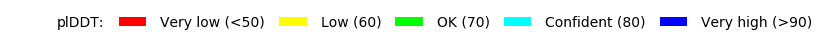

In [66]:
import py3Dmol
import glob
from colabfold.colabfold import plot_plddt_legend

# set different plotting parameters
rank_num = 1 # ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" # ["chain", "lDDT", "rainbow"]
show_sidechains = False
show_mainchains = False

jobname_prefix = ".custom" if msa_mode == "custom" else ""

if use_amber:
  pdb_filename = f"{jobname}{jobname_prefix}_relaxed_model_*_rank_{rank_num}.pdb"
else:
  pdb_filename = f"{jobname}{jobname_prefix}_unrelaxed_model_*_rank_{rank_num}.pdb"

pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
    
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view


show_pdb(rank_num, show_sidechains, show_mainchains, color).show()

if color == "lDDT":
  plot_plddt_legend().show()

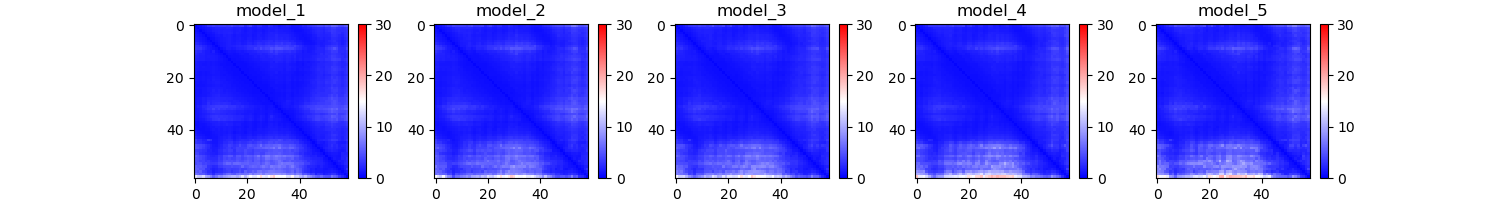

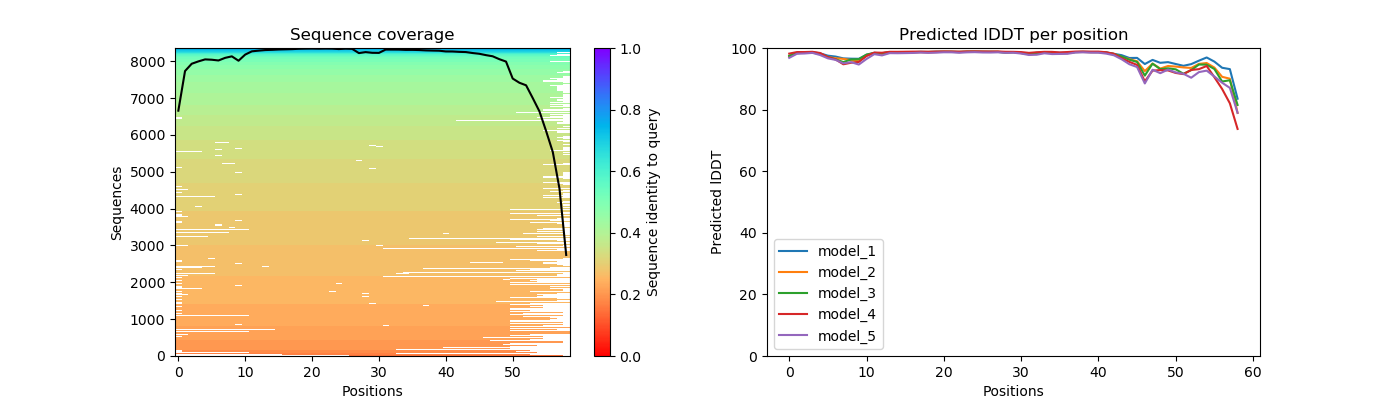

In [56]:

from IPython.display import Image
from IPython.display import display

pae = Image(f"{jobname}{jobname_prefix}_PAE.png")
plddt = Image(f"{jobname}{jobname_prefix}_coverage_lDDT.png")
display(pae, plddt)